In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
from tqdm.notebook import tqdm

Experimental setting
- 10000 Prompts from Alpaca Dataset
- LLM-generated response (fixed temperature / seed); not the actual answers
- Each prompt has:
    - Embedding of the prompt, with dimension (m, 4096)
    - Each generated token's embedding: (1, 4096) -> # remaining steps

ML Setting
- Classification: clip response length between 0-512, split to 10 equalwidth bins
- Train with CE loss
- Model: one hidden-layer MLP with 512 units
- Trained two models:
    - Prediction from prompt only: average value from each word's embedding
    - Prediction from generated token's embedding to # remaining steps

Average by time technique:
- At step T, probability of bin i: P(T, i) = DF * P(T - 1, i) + (1 - DF) * Current Prediction
- DF: decay factor

In [2]:
with open('eval/lllt_split0_testeval.pkl', 'rb') as fin:
    test_partition = pkl.load(fin)

In [3]:
test_partition[0].keys()

dict_keys(['id', 'prompt', 'iter', 'X', 'Y', 'train', 'prompt_label_uniform_bin', 'prompt_pred_uniform_bin', 'Y_label_uniform_bin', 'Y_pred_uniform_bin'])

Response length distribution by bins:
- Different from what we see previously with Alpaca dataset
- Because previous experiments (S3) use actual Alpaca answers rather than LLM-generated response

/home/weifan/anaconda3/envs/schedule/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


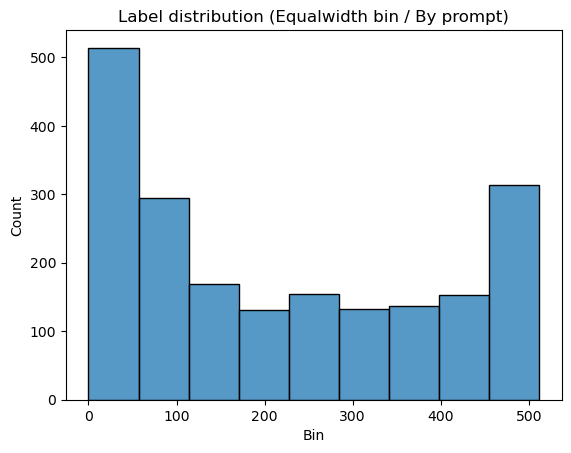

In [4]:
fig, ax = plt.subplots()
sns.histplot([x['iter'] for x in test_partition], bins=np.round(np.linspace(0, 512, 10)), ax=ax)

ax.set_xlabel('Bin')
ax.set_ylabel('Count')

ax.set_title('Label distribution (Equalwidth bin / By prompt)')
plt.show()

In [18]:
def softmax(mat):
    e = np.exp(mat - np.max(mat))
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else: # dim = 2
        return e / np.sum(e, axis=1, keepdims=True)


def conf_mat(Yp, Y, lims=None):
    if lims is None:
        min_val = np.min(Y).astype(int)
        max_val = np.max(Y).astype(int)
    else:
        min_val, max_val = lims
    print(min_val, max_val)
    confusion_matrix = np.zeros((max_val-min_val+1, max_val-min_val+1), dtype=int)
    for i in range(min_val,max_val+1):
        for j in range(min_val,max_val+1):
            confusion_matrix[i-1,j-1] = np.sum(np.logical_and(Y == i, Yp == j))

    bottom = np.sum(confusion_matrix, axis=0)
    bottom[bottom == 0] = 1
    confusion_matrix = confusion_matrix / bottom
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, bins=np.round(np.linspace(0, 512, 10)[1:]).astype(int), title='Confusion Matrix'):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(confusion_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xticks(range(len(bins)), bins)
    plt.yticks(range(len(bins)), bins)
    for i in range(len(bins)):
        for j in range(len(bins)):
            plt.text(j, i, f'{confusion_matrix[i,j]:.2f}', ha='center', va='center', color='black')
    plt.show()

Prediction from prompt-only model

1 9


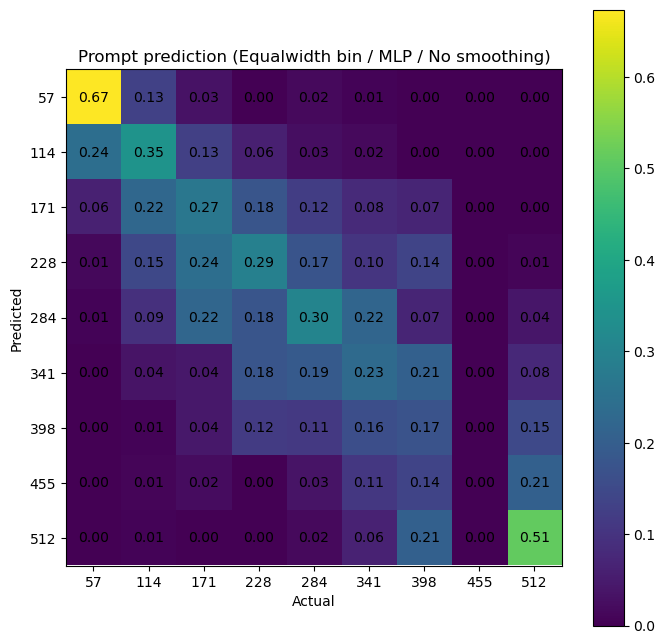

In [19]:
# prediction by prompt
Y_prompt = np.array([d['prompt_label_uniform_bin'] for d in test_partition])
Y_prompt_pred = np.concatenate([d['prompt_pred_uniform_bin'].reshape((1, -1)) for d in test_partition], axis=0)

confusion_matrix = conf_mat(np.argmax(Y_prompt_pred, axis=1), Y_prompt)
plot_confusion_matrix(confusion_matrix, title='Prompt prediction (Equalwidth bin / MLP / No smoothing)')

In [7]:
Y_pred = [d['Y_pred_uniform_bin'] for d in test_partition]

In [8]:
np.unique(np.concatenate([d['Y_label_uniform_bin'] for d in test_partition]), return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([98561, 75057, 62344, 54526, 46149, 38345, 30628, 22238, 14181]))

Label distribution (# remaining steps)

/home/weifan/anaconda3/envs/schedule/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


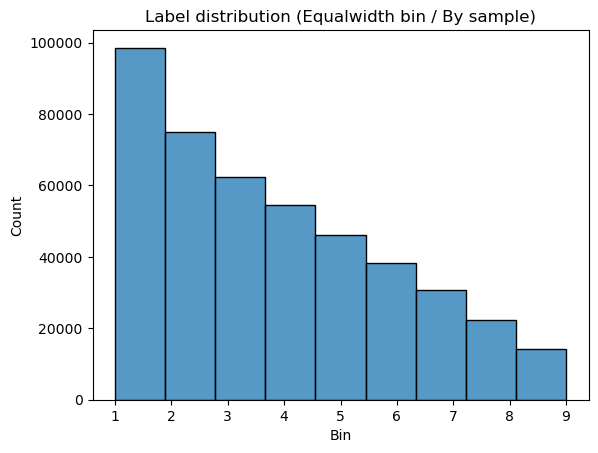

In [9]:
fig, ax = plt.subplots()
dat = np.concatenate([d['Y_label_uniform_bin'] for d in test_partition])
sns.histplot(
    dat,
    bins=np.unique(dat).shape[0],
    ax=ax
)

ax.set_xlabel('Bin')
ax.set_ylabel('Count')

ax.set_title('Label distribution (Equalwidth bin / By sample)')
plt.show()

1 9


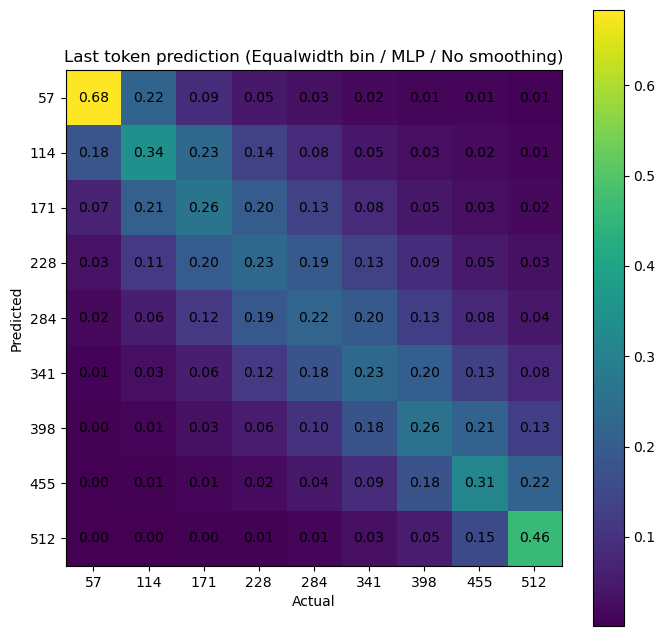

In [10]:
# Prediction with last generated token embeeding
Y = np.concatenate([d['Y_label_uniform_bin'] for d in test_partition])
Y_pred = np.concatenate([d['Y_pred_uniform_bin'] for d in test_partition], axis=0)

confusion_matrix = conf_mat(np.argmax(Y_pred, axis=1), Y, (1, 9))
plot_confusion_matrix(confusion_matrix, title='Last token prediction (Equalwidth bin / MLP / No smoothing)')

1 9


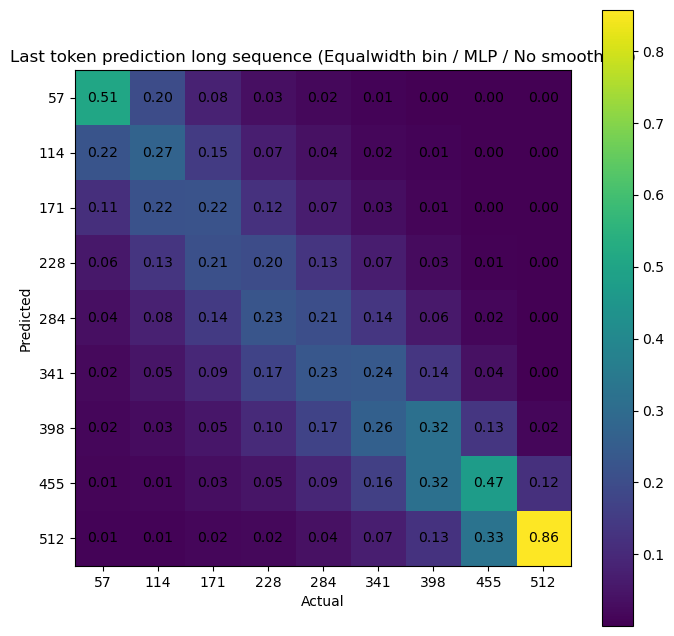

In [16]:
# Prediction with last generated token embeeding
long_test_partition = [d for d in test_partition if d['iter'] > 500]
Y = np.concatenate([d['Y_label_uniform_bin'] for d in long_test_partition])
Y_pred = np.concatenate([d['Y_pred_uniform_bin'] for d in long_test_partition], axis=0)

confusion_matrix = conf_mat(np.argmax(Y_pred, axis=1), Y, (1, 9))
plot_confusion_matrix(confusion_matrix, title='Last token prediction long sequence (Equalwidth bin / MLP / No smoothing)')

In [11]:
# prediction smoothing
def smooth_probs(Y_pred, Y_test, decay_factor=0.9):
    avg_probs = None
    Y_smoothed = []
    for i in tqdm(range(len(Y_test))):
        probs = Y_pred[i]
        if avg_probs is None:
            avg_probs = probs
        else:
            avg_probs = decay_factor * avg_probs + (1 - decay_factor) * probs
        Y_smoothed.append(avg_probs)
        if Y_test[i] == 0:
            avg_probs = None
    
    return np.array(Y_smoothed)

Smoothing - tried 0.9 / 0.95 DF

In [12]:
# join prompt-based and token-based predictions

Y_all = list()
Y_pred_all = list()

for dat in test_partition:
    prompt_proba = dat['prompt_pred_uniform_bin'].reshape((1, -1))
    token_proba = dat['Y_pred_uniform_bin']

    Y_pred_all.append(prompt_proba)
    Y_pred_all.append(token_proba)

    join_label = np.zeros(len(dat['Y_label_uniform_bin']) + 1)
    join_label[0] = dat['prompt_label_uniform_bin']
    join_label[1:] = dat['Y_label_uniform_bin']

    Y_all.append(join_label)

Y_all = np.concatenate(Y_all)
Y_pred_all = np.concatenate(Y_pred_all, axis=0)

  0%|          | 0/444029 [00:00<?, ?it/s]

1 9


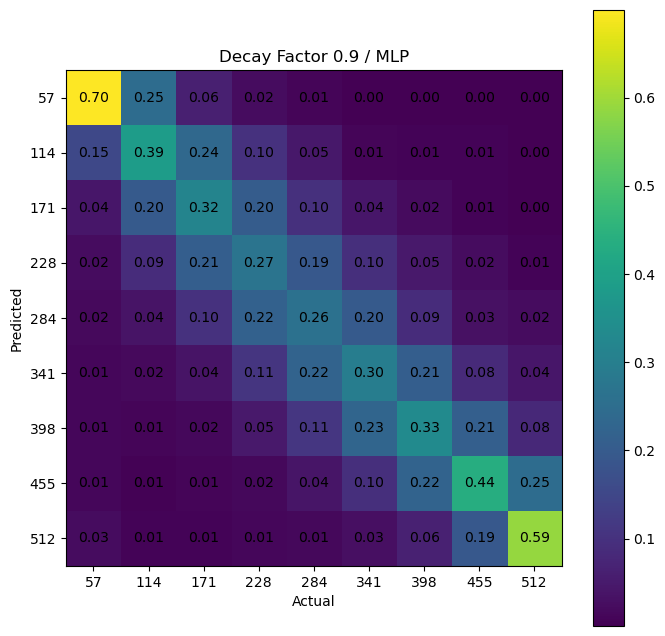

In [13]:
Y_smoothed = smooth_probs(Y_pred_all, Y_all, 0.9)
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y_all)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.9 / MLP')

  0%|          | 0/444029 [00:00<?, ?it/s]

1 9


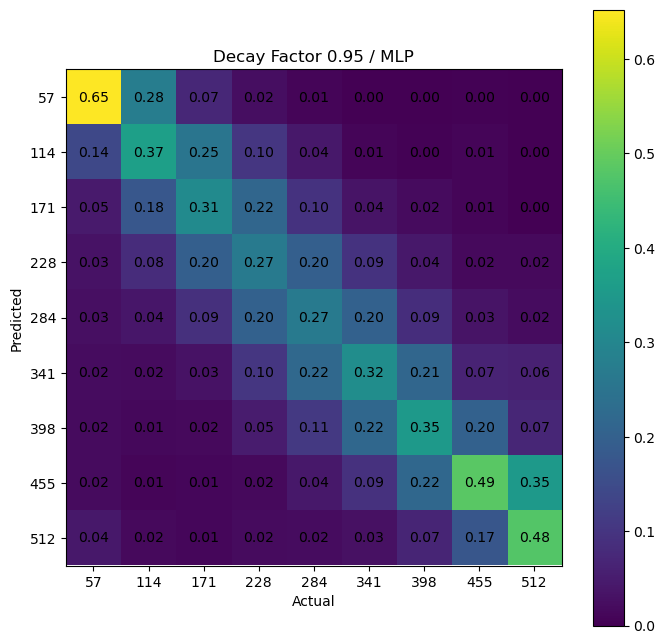

In [14]:
Y_smoothed = smooth_probs(Y_pred_all, Y_all, 0.95)
confusion_matrix = conf_mat(np.argmax(Y_smoothed, axis=1), Y_all)
plot_confusion_matrix(confusion_matrix, title='Decay Factor 0.95 / MLP')

Next step:
- Separate the plot by overall length of the job
- X-axis: remaining steps, Y-axis: accuracy; plot for small/medium/long bins
- Non-equalwidth bins

In [17]:
p = '../chunwei-data/all_layers_1k.json'

import json

with open(p, 'r') as fin:
    js = json.load(fin)

In [18]:
ids = [js['records'][i]['record_id'] for i in range(len(js['records']))]

In [19]:
with open('dataset/alpaca_chunwei/train.json', 'r') as fin:
    train = json.load(fin)

In [19]:
js['records'][20]['iteration_count']

12

In [27]:
layer_nums = list()
import numpy as np
for rec in js['records'][1:]:
    for itera in rec['iterations'][1:]:
        if len(itera['layers']) == 31:
            print(rec['record_id'])

182
296
372
467
708
943


In [25]:
np.unique(layer_nums)

array([31, 32])

In [1]:
import os

fnames = os.listdir('../chunwei-data/llama_layer_tensor')

In [16]:
tf = sorted([x for x in fnames if x.startswith('L5_2024-08-24 05:12:51')])
tf

['L5_2024-08-24 05:12:51.010073+.pt', 'L5_2024-08-24 05:12:51.368359+.pt']

In [8]:
prefix = [f.split('_')[0] for f in fnames]
prefix = sorted(list(set(prefix)))
prefix

['L0',
 'L1',
 'L10',
 'L11',
 'L12',
 'L13',
 'L14',
 'L15',
 'L16',
 'L17',
 'L18',
 'L19',
 'L2',
 'L20',
 'L21',
 'L22',
 'L23',
 'L24',
 'L25',
 'L26',
 'L27',
 'L28',
 'L29',
 'L3',
 'L30',
 'L31',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9']